In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from datetime import datetime

%matplotlib inline

In [11]:
DATA_HOME="/wd/data/MNIST/"

In [5]:
print("pandas: ", pd.__version__,
    "\nnumpy: ", np.__version__,
    "\ntensorflow: ", tf.__version__
      
     )

pandas:  0.20.1 
numpy:  1.12.1 
tensorflow:  1.2.1


In [6]:
def normalize_fetures(X):
    return X * 0.98 / 255 + 0.01

def normalize_labels(y):
    y = OneHotEncoder(sparse=False).fit_transform(y)
    y[y == 0] = 0.01
    y[y == 1] = 0.99
    return y

In [7]:
class Batch():    
    def __init__(self, total, batch_size):
        self.total = total
        self.batch_size = batch_size
        self.current = 0

    def next(self):
        max_index = self.current + self.batch_size
        indices = [i if i < self.total else i - self.total 
                       for i in range(self.current, max_index)]
        self.current = max_index % self.total
        return indices 

b = Batch(10, 3)
print(b.next())
print(b.next())
print(b.next())
print(b.next())
print(b.next())
print(b.next())
print(b.next())
print(b.next())
print(b.next())
print(b.next())
print(b.next())
print(b.next())

[0, 1, 2]
[3, 4, 5]
[6, 7, 8]
[9, 0, 1]
[2, 3, 4]
[5, 6, 7]
[8, 9, 0]
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[0, 1, 2]
[3, 4, 5]


In [9]:
list(range(40, -10))

[]

In [10]:
a = np.random.rand(10, 3)
print(a)
b = Batch(total = 10, batch_size = 3)
print(a[b.next()])
print(a[b.next()])

[[ 0.17118558  0.974977    0.95520643]
 [ 0.06174732  0.86466603  0.37670848]
 [ 0.52669215  0.99409666  0.14322462]
 [ 0.22161793  0.41811251  0.76237563]
 [ 0.19797656  0.86617836  0.76976444]
 [ 0.80022383  0.50410787  0.26249855]
 [ 0.92547404  0.9051367   0.3064223 ]
 [ 0.76536313  0.07964615  0.61420944]
 [ 0.50653045  0.50796204  0.26054975]
 [ 0.3460666   0.34757179  0.82002295]]
[[ 0.17118558  0.974977    0.95520643]
 [ 0.06174732  0.86466603  0.37670848]
 [ 0.52669215  0.99409666  0.14322462]]
[[ 0.22161793  0.41811251  0.76237563]
 [ 0.19797656  0.86617836  0.76976444]
 [ 0.80022383  0.50410787  0.26249855]]


In [12]:
df_train = pd.read_csv(DATA_HOME + "/mnist_train.csv", header=None, dtype= np.float32)
X_train = normalize_fetures(df_train.iloc[:, 1:].values)
y_train = df_train.iloc[:, 0].values

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
print("X_train", X_train.dtype, X_train.shape, "y_train", y_train.dtype, y_train.shape)

X_train float32 (60000, 784) y_train int64 (60000,)


In [13]:
df_test = pd.read_csv(DATA_HOME + "/mnist_test.csv", header=None, dtype=np.float32)
X_test = normalize_fetures(df_test.iloc[:, 1:].values)
y_test = label_encoder.transform(df_test.iloc[:, 0].values)
print("X_test", X_test.dtype, X_test.shape, "y_test: ", y_test.dtype, y_test.shape)

X_test float32 (10000, 784) y_test:  int64 (10000,)


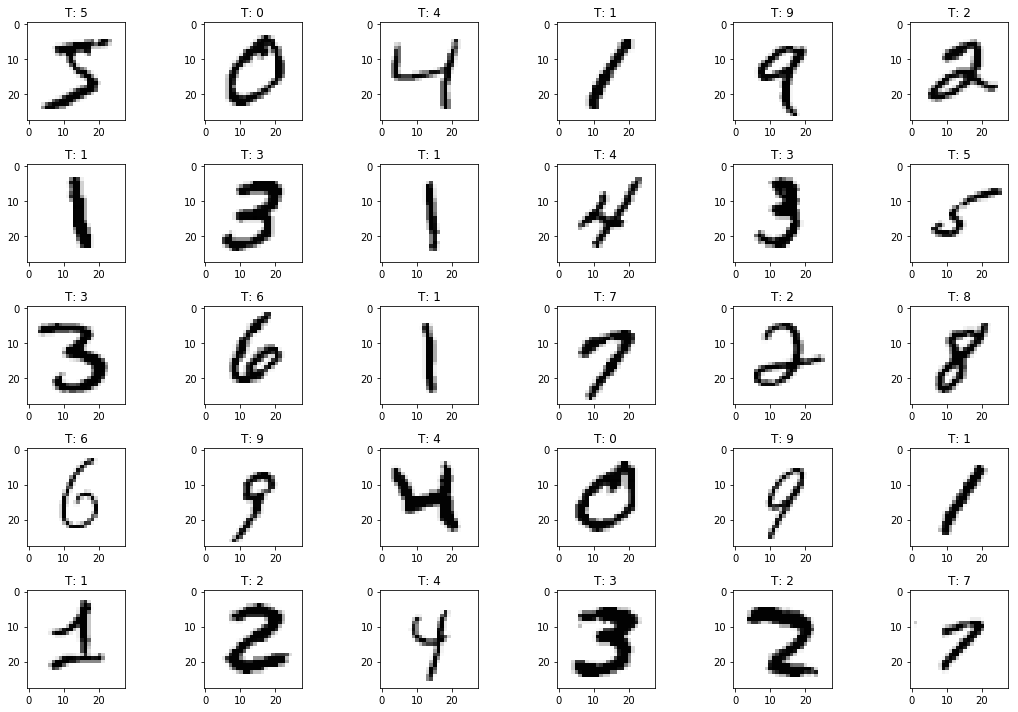

In [14]:
fig, _ = plt.subplots(5, 6, figsize = (15, 10))
for i, ax in enumerate(fig.axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap="Greys", interpolation="none")
    ax.set_title("T: %d" % y_train[i])

plt.tight_layout()

In [15]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
accuracy_score(y_pred=lr.predict(X_test), y_true = y_test)

0.92020000000000002

In [30]:
n, d = X_train.shape
num_classes = 10
learning_rate = 0.1
epochs = 10000
batch_size = 100

X = tf.placeholder(tf.float32, shape = [None, d])
y_true = tf.placeholder(tf.int64, shape = None)
y_true_oh = tf.one_hot(indices = y_true, depth = num_classes, on_value=0.9999, off_value=0.0001, dtype=tf.float32)
print("y_true_oh: ", y_true_oh, "shape: ", y_true_oh.get_shape())

W = tf.Variable(tf.random_normal([d, num_classes], seed = 100))
b = tf.Variable(tf.random_normal([num_classes], seed = 123))
y_pred = tf.matmul(X, W) + b
print("y_pred: ", y_pred)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels= y_true_oh, logits = y_pred))

solver = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy
                                                                   + tf.reduce_mean(tf.abs(W))
                                                                   + tf.reduce_mean(tf.abs(b)))

y_pred_cls = tf.argmax(tf.nn.softmax(y_pred), axis = 1)
print("y_pred_cls: ", y_pred_cls)

correct_mask = tf.equal(y_pred_cls, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_mask, tf.float32))

start_time = datetime.now()
b = Batch(n, batch_size)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(epochs):
        batch = b.next()
        X_batch, y_batch = X_train[batch, ], y_train[batch, ]
        sess.run(solver, feed_dict={X: X_batch, y_true: y_batch})
        ans = sess.run(accuracy, feed_dict={X: X_test, y_true: y_test})
        if step % 100 == 0 or step == epochs-1:
            elapsed = (datetime.now() - start_time).seconds
            print("Step: %4d, elapsed: %4d, accuracy on test dataset: %.4f" % (step, elapsed, ans))

y_true_oh:  Tensor("one_hot_5:0", dtype=float32) shape:  <unknown>
y_pred:  Tensor("add_15:0", shape=(?, 10), dtype=float32)
y_pred_cls:  Tensor("ArgMax_5:0", shape=(?,), dtype=int64)
Step:    0, elapsed:    0, accuracy on test dataset: 0.1203
Step:  100, elapsed:    1, accuracy on test dataset: 0.4390
Step:  200, elapsed:    3, accuracy on test dataset: 0.6013
Step:  300, elapsed:    5, accuracy on test dataset: 0.6726
Step:  400, elapsed:    7, accuracy on test dataset: 0.7161
Step:  500, elapsed:    9, accuracy on test dataset: 0.7399
Step:  600, elapsed:   11, accuracy on test dataset: 0.7604
Step:  700, elapsed:   13, accuracy on test dataset: 0.7714
Step:  800, elapsed:   15, accuracy on test dataset: 0.7875
Step:  900, elapsed:   17, accuracy on test dataset: 0.7958
Step: 1000, elapsed:   18, accuracy on test dataset: 0.8028
Step: 1100, elapsed:   20, accuracy on test dataset: 0.8083
Step: 1200, elapsed:   22, accuracy on test dataset: 0.8164
Step: 1300, elapsed:   24, accuracy 

In [22]:
start_time = datetime.now()

In [27]:
d = (datetime.now() - start_time).seconds

In [28]:
d.seconds

128